# Imports

In [1]:
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix, f1_score,
                             make_scorer, precision_score, recall_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedShuffleSplit, cross_val_predict,
                                     cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (MinMaxScaler, PolynomialFeatures,
                                   StandardScaler, LabelEncoder)


#for quick printing of scores
def model_evaluation(y_true , y_pred):
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred, average="micro"))
    print('Recall:', recall_score(y_true, y_pred, average="micro"))
    print('F1 score:', f1_score(y_true, y_pred, average="micro"))
    print('Cohen\'s Kappa', cohen_kappa_score(y_true, y_pred))
    pass

kappa_score = make_scorer(cohen_kappa_score)

def model_evaluation_cv(estimator, X , y, cv=3):
    cv_acc = cross_val_score(estimator, X, y, cv=cv, scoring="accuracy")
    cv_prc = cross_val_score(estimator, X, y, cv=cv, scoring="precision_micro")
    cv_rec = cross_val_score(estimator, X, y, cv=cv, scoring="recall_micro")
    cv_f1 = cross_val_score(estimator, X, y, cv=cv, scoring="f1_micro")
    cv_kappa = cross_val_score(estimator, X, y, cv=cv, scoring=kappa_score)

    print('Mean Accuracy:', cv_acc.mean(), "Standard Deviation", cv_acc.std())
    print('Mean Precision:', cv_prc.mean(), "Standard Deviation", cv_prc.std())
    print('Mean Recall:', cv_rec.mean(), "Standard Deviation", cv_rec.std())
    print('Mean F1 score:', cv_f1.mean(), "Standard Deviation", cv_f1.std())
    print('Mean Cohen\'s Kappa', cv_kappa.mean(), "Standard Deviation",
          cv_kappa.std())
    pass

# Data Preparation and Exploration

In [2]:
sarafu_testset = pd.read_csv(os.path.join("sdsh2022_sarafu_testset.csv"))
sarafu_trainset = pd.read_csv(os.path.join("sdsh2022_sarafu_trainset.csv"))
sarafu_transactions = pd.read_csv(os.path.join("sdsh2022_sarafu_transactions copy.csv"))
sarafu_users = pd.read_csv(os.path.join("sdsh2022_sarafu_users.csv"))

In [3]:
sarafu_users["gender"].value_counts()

male       15766
female     12751
unknown    12325
Name: gender, dtype: int64

In [4]:
sarafu_users["account_type"].value_counts()

individual    40709
group           133
Name: account_type, dtype: int64

In [5]:
sarafu_users["area_name"].value_counts()

Kinango Kwale          23059
Mukuru Nairobi          9749
Misc Nairobi            4952
unknown                 1593
Misc Mombasa             520
Kilifi                   407
Nyanza                   386
Misc Rural Counties      152
Kisauni Mombasa           24
Name: area_name, dtype: int64

In [6]:
sarafu_users["area_type"].value_counts()

rural        23597
urban        15245
unknown       1593
periurban      407
Name: area_type, dtype: int64

In [7]:
sarafu_users["business_type"].value_counts()

food           10556
farming         9356
labour          8066
shop            5065
fuel/energy     2757
transport       1455
other           1316
water           1005
education        514
environment      297
health           249
savings          159
faith             30
government        17
Name: business_type, dtype: int64

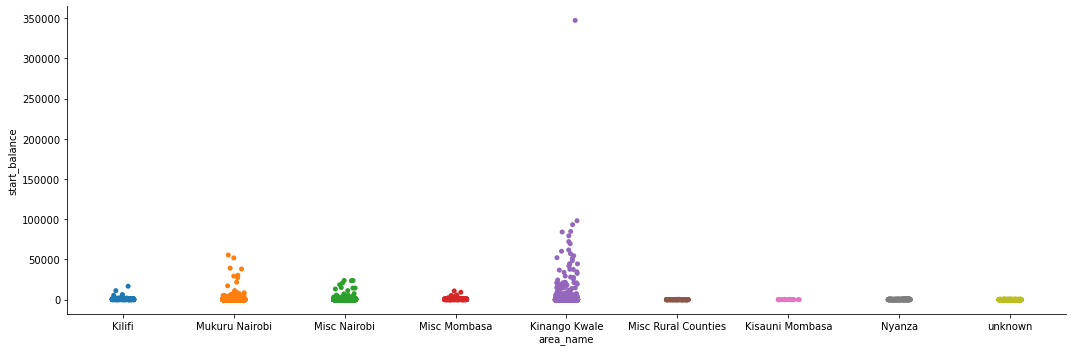

In [8]:
sns.catplot(data=sarafu_users, x="area_name", y="start_balance", aspect=3)

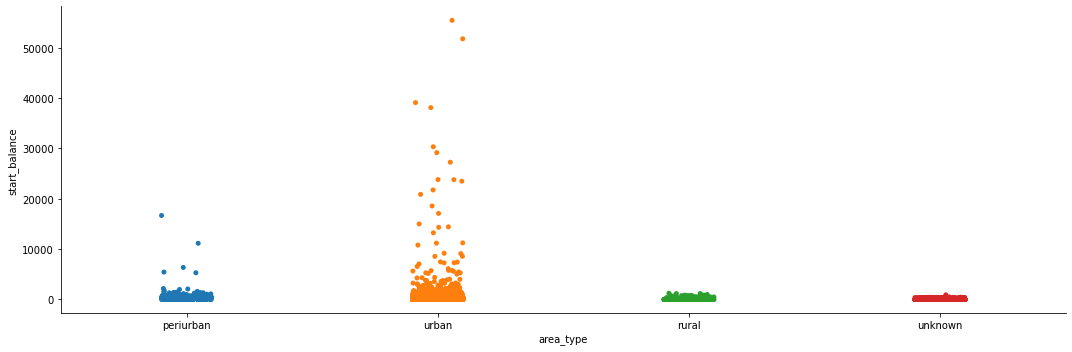

In [9]:
sns.catplot(data=sarafu_users[sarafu_users["area_name"] != "Kinango Kwale"], 
            x="area_type", y="start_balance", aspect=3)

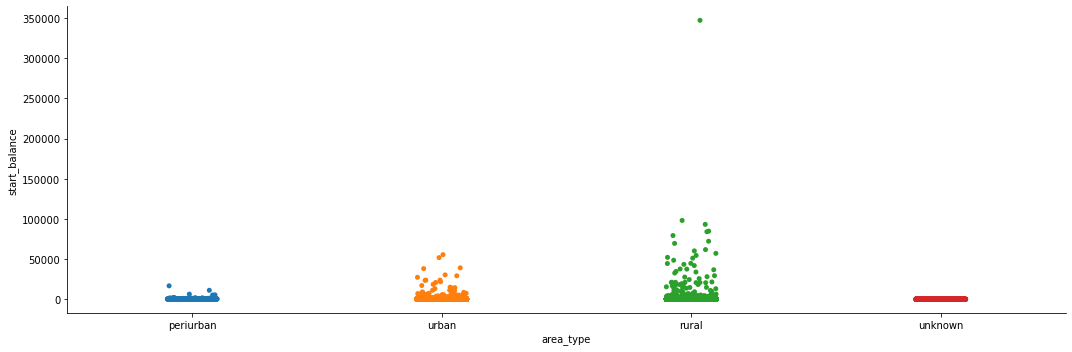

In [10]:
sns.catplot(data=sarafu_users, x="area_type", y="start_balance", aspect=3)

## Some Feature Engineering

Add some user data to the features that we'll use.

In [11]:
trainset = pd.merge(sarafu_trainset, sarafu_users, how='inner', on="id")
trainset

,id,inactive,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,33064,1,individual,2020-08-10 13:28:13.820557,unknown,Kinango Kwale,rural,food,0.00
1,34782,0,individual,2020-08-19 11:13:07.797863,male,Mukuru Nairobi,urban,shop,0.00
2,30712,1,individual,2020-07-28 07:37:13.403603,male,Kinango Kwale,rural,farming,0.00
3,35689,0,individual,2020-08-24 12:27:00.324002,unknown,Kinango Kwale,rural,food,0.00
4,40015,0,individual,2020-10-09 09:29:44.204909,male,Kinango Kwale,rural,farming,0.00
...,...,...,...,...,...,...,...,...,...
5146,32376,1,individual,2020-08-06 07:39:53.539983,unknown,Misc Nairobi,urban,food,0.00
5147,36465,0,individual,2020-08-29 15:52:00.924168,unknown,Mukuru Nairobi,urban,labour,0.00
5148,36545,0,individual,2020-08-31 09:10:10.087413,unknown,Kinango Kwale,rural,food,0.00
5149,36932,0,individual,2020-09-04 13:40:20.915654,unknown,Kinango Kwale,rural,fuel/energy,0.00


In [12]:
testset = pd.merge(sarafu_testset, sarafu_users, how='inner', on="id")
testset

,id,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,18774,individual,2020-05-05 06:45:53.090852,unknown,Kinango Kwale,rural,other,0.00
1,15108,individual,2020-04-20 09:13:26.342679,female,Mukuru Nairobi,urban,labour,100.98
2,22211,individual,2020-05-25 11:05:31.112923,male,Mukuru Nairobi,urban,labour,0.00
3,30692,individual,2020-07-28 06:49:52.117954,male,Kinango Kwale,rural,fuel/energy,0.00
4,37399,individual,2020-09-09 12:29:29.915180,male,Mukuru Nairobi,urban,food,0.00
...,...,...,...,...,...,...,...,...
1712,27925,individual,2020-07-08 04:06:48.178385,female,Mukuru Nairobi,urban,shop,0.00
1713,20245,individual,2020-05-12 13:16:21.638127,male,Nyanza,rural,transport,0.00
1714,36065,individual,2020-08-26 09:40:58.828007,female,Mukuru Nairobi,urban,food,0.00
1715,36739,individual,2020-09-02 09:57:03.571248,unknown,Mukuru Nairobi,urban,labour,0.00


## Turn timestamps into weeks.

Trainset:

In [13]:
trainset_registration_week = [
    pd.Timestamp(trainset["registration_time"][i]).week for i in 
    range(len(trainset))
    ]

trainset.registration_time = trainset_registration_week
trainset

,id,inactive,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,33064,1,individual,33,unknown,Kinango Kwale,rural,food,0.00
1,34782,0,individual,34,male,Mukuru Nairobi,urban,shop,0.00
2,30712,1,individual,31,male,Kinango Kwale,rural,farming,0.00
3,35689,0,individual,35,unknown,Kinango Kwale,rural,food,0.00
4,40015,0,individual,41,male,Kinango Kwale,rural,farming,0.00
...,...,...,...,...,...,...,...,...,...
5146,32376,1,individual,32,unknown,Misc Nairobi,urban,food,0.00
5147,36465,0,individual,35,unknown,Mukuru Nairobi,urban,labour,0.00
5148,36545,0,individual,36,unknown,Kinango Kwale,rural,food,0.00
5149,36932,0,individual,36,unknown,Kinango Kwale,rural,fuel/energy,0.00


Testset:

In [14]:
testset_registration_week = [
    pd.Timestamp(testset["registration_time"][i]).week for i in 
    range(len(testset))
    ]

testset.registration_time = testset_registration_week
testset

,id,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,18774,individual,19,unknown,Kinango Kwale,rural,other,0.00
1,15108,individual,17,female,Mukuru Nairobi,urban,labour,100.98
2,22211,individual,22,male,Mukuru Nairobi,urban,labour,0.00
3,30692,individual,31,male,Kinango Kwale,rural,fuel/energy,0.00
4,37399,individual,37,male,Mukuru Nairobi,urban,food,0.00
...,...,...,...,...,...,...,...,...
1712,27925,individual,28,female,Mukuru Nairobi,urban,shop,0.00
1713,20245,individual,20,male,Nyanza,rural,transport,0.00
1714,36065,individual,35,female,Mukuru Nairobi,urban,food,0.00
1715,36739,individual,36,unknown,Mukuru Nairobi,urban,labour,0.00


Transactions:

In [15]:
transactions_week = [
    pd.Timestamp(sarafu_transactions["time"][i]).week for i in 
    range(len(sarafu_transactions))
    ]

sarafu_transactions["time"] = transactions_week
sarafu_transactions

,time,id,target,amount
0,18,14799,2159,100.0
1,18,14799,2159,100.0
2,18,15928,15929,200.0
3,18,15975,16552,500.0
4,18,15975,16542,200.0
...,...,...,...,...
375481,44,-1,40841,50.0
375482,44,40841,39764,50.0
375483,44,225,324,150.0
375484,44,21390,5829,1200.0


## Remove account_type, id, and area type

In [334]:
testset

,id,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,18774,individual,19,unknown,Kinango Kwale,rural,other,0.00
1,15108,individual,17,female,Mukuru Nairobi,urban,labour,100.98
2,22211,individual,22,male,Mukuru Nairobi,urban,labour,0.00
3,30692,individual,31,male,Kinango Kwale,rural,fuel/energy,0.00
4,37399,individual,37,male,Mukuru Nairobi,urban,food,0.00
...,...,...,...,...,...,...,...,...
1712,27925,individual,28,female,Mukuru Nairobi,urban,shop,0.00
1713,20245,individual,20,male,Nyanza,rural,transport,0.00
1714,36065,individual,35,female,Mukuru Nairobi,urban,food,0.00
1715,36739,individual,36,unknown,Mukuru Nairobi,urban,labour,0.00


In [343]:
trainset_dropped = trainset.drop(columns=["account_type", "id", "area_type"])
testset_dropped = testset.drop(columns=["account_type",  "area_type"])

## Label Encoder

Encode gender.

In [344]:
label_encoder = LabelEncoder()
labels = [i for i in set(trainset_dropped["gender"])]
label_encoder.fit(labels)
trainset_dropped["gender"] = label_encoder.transform(trainset_dropped["gender"])

label_encoder = LabelEncoder()
labels = [i for i in set(testset_dropped["gender"])]
label_encoder.fit(labels)
testset_dropped["gender"] = label_encoder.transform(testset_dropped["gender"])

In [345]:
trainset_dropped

,inactive,registration_time,gender,area_name,business_type,start_balance
0,1,33,2,Kinango Kwale,food,0.00
1,0,34,1,Mukuru Nairobi,shop,0.00
2,1,31,1,Kinango Kwale,farming,0.00
3,0,35,2,Kinango Kwale,food,0.00
4,0,41,1,Kinango Kwale,farming,0.00
...,...,...,...,...,...,...
5146,1,32,2,Misc Nairobi,food,0.00
5147,0,35,2,Mukuru Nairobi,labour,0.00
5148,0,36,2,Kinango Kwale,food,0.00
5149,0,36,2,Kinango Kwale,fuel/energy,0.00


Encode area name.

In [346]:
label_encoder = LabelEncoder()
labels = [i for i in set(trainset_dropped["area_name"])]
label_encoder.fit(labels)
trainset_dropped["area_name"] = label_encoder.transform(trainset_dropped["area_name"])

label_encoder = LabelEncoder()
labels = [i for i in set(testset_dropped["area_name"])]
label_encoder.fit(labels)
testset_dropped["area_name"] = label_encoder.transform(testset_dropped["area_name"])

Encode business type.

In [347]:
label_encoder = LabelEncoder()
labels = [i for i in set(trainset_dropped["business_type"])]
label_encoder.fit(labels)
trainset_dropped["business_type"] = label_encoder.transform(trainset_dropped["business_type"])

label_encoder = LabelEncoder()
labels = [i for i in set(testset_dropped["business_type"])]
label_encoder.fit(labels)
testset_dropped["business_type"] = label_encoder.transform(testset_dropped["business_type"])

In [348]:
testset_dropped

,id,registration_time,gender,area_name,business_type,start_balance
0,18774,19,2,1,7,0.00
1,15108,17,0,5,6,100.98
2,22211,22,1,5,6,0.00
3,30692,31,1,1,4,0.00
4,37399,37,1,5,3,0.00
...,...,...,...,...,...,...
1712,27925,28,0,5,9,0.00
1713,20245,20,1,6,10,0.00
1714,36065,35,0,5,3,0.00
1715,36739,36,2,5,6,0.00


In [349]:
X = trainset_dropped.drop(columns="inactive")
Y = trainset_dropped["inactive"]

Now we can possibly add weekly transaction info, aggregate and/or average.

In [350]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
model_evaluation_cv(rf, X, Y)

Mean Accuracy: 0.6961754999029316 Standard Deviation 0.005633320958472901
Mean Precision: 0.7023878858474083 Standard Deviation 0.0026476765088304837
Mean Recall: 0.6998641040574646 Standard Deviation 0.0042621817899631724
Mean F1 score: 0.6965637740244612 Standard Deviation 0.005401059112111676
Mean Cohen's Kappa 0.40500857545870345 Standard Deviation 0.004882090469883227


In [351]:
knn = KNeighborsClassifier()

model_evaluation_cv(knn, X, Y)

Mean Accuracy: 0.6829741797709182 Standard Deviation 0.007523906959843135
Mean Precision: 0.6829741797709182 Standard Deviation 0.007523906959843135
Mean Recall: 0.6829741797709182 Standard Deviation 0.007523906959843135
Mean F1 score: 0.6829741797709182 Standard Deviation 0.007523906959843135
Mean Cohen's Kappa 0.3624214778543649 Standard Deviation 0.01708410004216555


In [352]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

model_evaluation_cv(gb, X, Y)

Mean Accuracy: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean Precision: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean Recall: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean F1 score: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean Cohen's Kappa 0.44848046767788824 Standard Deviation 0.028318617601404698


Get transactions related to the users:

In [353]:
t = trainset.drop(columns=["account_type", "area_type"])
user_transactions = pd.merge(t, sarafu_transactions, how="inner", on="id")

label_encoder = LabelEncoder()
labels = [i for i in set(user_transactions["business_type"])]
label_encoder.fit(labels)
user_transactions["business_type"] = label_encoder.transform(user_transactions["business_type"])

label_encoder = LabelEncoder()
labels = [i for i in set(user_transactions["area_name"])]
label_encoder.fit(labels)
user_transactions["area_name"] = label_encoder.transform(user_transactions["area_name"])

label_encoder = LabelEncoder()
labels = [i for i in set(user_transactions["gender"])]
label_encoder.fit(labels)
user_transactions["gender"] = label_encoder.transform(user_transactions["gender"])

user_transactions

,id,inactive,registration_time,gender,area_name,business_type,start_balance,time,target,amount
0,33064,1,33,2,1,4,0.00,33,6521,20.0
1,33064,1,33,2,1,4,0.00,33,3866,400.0
2,33064,1,33,2,1,4,0.00,33,3866,20.0
3,33064,1,33,2,1,4,0.00,34,3866,121.0
4,34782,0,34,1,6,11,0.00,34,7332,20.0
...,...,...,...,...,...,...,...,...,...,...
133427,10848,0,10,0,1,3,1223.37,41,11001,10000.0
133428,10848,0,10,0,1,3,1223.37,41,11001,15000.0
133429,10848,0,10,0,1,3,1223.37,42,11001,20000.0
133430,10848,0,10,0,1,3,1223.37,42,11001,200.0


In [354]:
te = testset
user_transactions_test = pd.merge(te, sarafu_transactions, how="inner", on="id")

label_encoder = LabelEncoder()
labels = [i for i in set(user_transactions_test["business_type"])]
label_encoder.fit(labels)
user_transactions_test["business_type"] = label_encoder.transform(user_transactions_test["business_type"])

label_encoder = LabelEncoder()
labels = [i for i in set(user_transactions_test["area_name"])]
label_encoder.fit(labels)
user_transactions_test["area_name"] = label_encoder.transform(user_transactions_test["area_name"])

label_encoder = LabelEncoder()
labels = [i for i in set(user_transactions_test["gender"])]
label_encoder.fit(labels)
user_transactions_test["gender"] = label_encoder.transform(user_transactions_test["gender"])

user_transactions_test.drop(columns=["area_type", "account_type"], inplace=True)
user_transactions_test

,id,registration_time,gender,area_name,business_type,start_balance,time,target,amount
0,18774,19,2,1,7,0.0,19,4065,20.0
1,18774,19,2,1,7,0.0,21,18773,200.0
2,18774,19,2,1,7,0.0,22,18771,200.0
3,18774,19,2,1,7,0.0,22,18771,100.0
4,18774,19,2,1,7,0.0,23,18771,200.0
...,...,...,...,...,...,...,...,...,...
44100,36739,36,2,5,6,0.0,36,36712,50.0
44101,36739,36,2,5,6,0.0,36,36712,350.0
44102,38736,39,2,1,2,0.0,39,12502,20.0
44103,38736,39,2,1,2,0.0,39,-1,350.0


In [355]:
X2 = user_transactions.drop(columns=["id","inactive"])
Y2 = user_transactions["inactive"]

In [356]:
gb = GradientBoostingClassifier()

model_evaluation_cv(gb, X2, Y2)

Mean Accuracy: 0.8851325390054928 Standard Deviation 0.008936605258794797
Mean Precision: 0.884915203094106 Standard Deviation 0.009061272170448931
Mean Recall: 0.8851325390054928 Standard Deviation 0.008936605258794797
Mean F1 score: 0.8850426069042293 Standard Deviation 0.00898712647179817
Mean Cohen's Kappa 0.4344239931401568 Standard Deviation 0.05131981925264415


# Create The Ultimate Dataset

In [168]:
user_transactions["id"].unique()

array([33064, 34782, 30712, ..., 36545, 36932, 10848], dtype=int64)

In [156]:
user_transactions["time"].unique()

array([33, 34, 43, 31, 35, 37, 41, 42, 29, 40, 36, 39, 38, 21, 22, 24, 25,
       28, 30, 32, 26, 18, 20, 23, 27, 44, 19], dtype=int64)

In [180]:
trainset_id = trainset.drop(columns=["account_type", "area_type"])
trainset_id

,id,inactive,registration_time,gender,area_name,business_type,start_balance
0,33064,1,33,unknown,Kinango Kwale,food,0.00
1,34782,0,34,male,Mukuru Nairobi,shop,0.00
2,30712,1,31,male,Kinango Kwale,farming,0.00
3,35689,0,35,unknown,Kinango Kwale,food,0.00
4,40015,0,41,male,Kinango Kwale,farming,0.00
...,...,...,...,...,...,...,...
5146,32376,1,32,unknown,Misc Nairobi,food,0.00
5147,36465,0,35,unknown,Mukuru Nairobi,labour,0.00
5148,36545,0,36,unknown,Kinango Kwale,food,0.00
5149,36932,0,36,unknown,Kinango Kwale,fuel/energy,0.00


In [357]:
testset_dropped

,id,registration_time,gender,area_name,business_type,start_balance
0,18774,19,2,1,7,0.00
1,15108,17,0,5,6,100.98
2,22211,22,1,5,6,0.00
3,30692,31,1,1,4,0.00
4,37399,37,1,5,3,0.00
...,...,...,...,...,...,...
1712,27925,28,0,5,9,0.00
1713,20245,20,1,6,10,0.00
1714,36065,35,0,5,3,0.00
1715,36739,36,2,5,6,0.00


In [194]:
label_encoder = LabelEncoder()
labels = [i for i in set(trainset_id["business_type"])]
label_encoder.fit(labels)
trainset_id["business_type"] = label_encoder.transform(trainset_id["business_type"])

label_encoder = LabelEncoder()
labels = [i for i in set(trainset_id["area_name"])]
label_encoder.fit(labels)
trainset_id["area_name"] = label_encoder.transform(trainset_id["area_name"])

label_encoder = LabelEncoder()
labels = [i for i in set(trainset_id["gender"])]
label_encoder.fit(labels)
trainset_id["gender"] = label_encoder.transform(trainset_id["gender"])

trainset_id

,id,inactive,registration_time,gender,area_name,business_type,start_balance
0,33064,1,33,2,1,4,0.00
1,34782,0,34,1,6,11,0.00
2,30712,1,31,1,1,3,0.00
3,35689,0,35,2,1,4,0.00
4,40015,0,41,1,1,3,0.00
...,...,...,...,...,...,...,...
5146,32376,1,32,2,4,4,0.00
5147,36465,0,35,2,6,8,0.00
5148,36545,0,36,2,1,4,0.00
5149,36932,0,36,2,1,5,0.00


In [218]:
user_transactions

,id,inactive,registration_time,gender,area_name,business_type,start_balance,time,target,amount
0,33064,1,33,2,1,4,0.00,33,6521,20.0
1,33064,1,33,2,1,4,0.00,33,3866,400.0
2,33064,1,33,2,1,4,0.00,33,3866,20.0
3,33064,1,33,2,1,4,0.00,34,3866,121.0
4,34782,0,34,1,6,11,0.00,34,7332,20.0
...,...,...,...,...,...,...,...,...,...,...
133427,10848,0,10,0,1,3,1223.37,41,11001,10000.0
133428,10848,0,10,0,1,3,1223.37,41,11001,15000.0
133429,10848,0,10,0,1,3,1223.37,42,11001,20000.0
133430,10848,0,10,0,1,3,1223.37,42,11001,200.0


In [358]:
user_transactions_test

,id,registration_time,gender,area_name,business_type,start_balance,time,target,amount
0,18774,19,2,1,7,0.0,19,4065,20.0
1,18774,19,2,1,7,0.0,21,18773,200.0
2,18774,19,2,1,7,0.0,22,18771,200.0
3,18774,19,2,1,7,0.0,22,18771,100.0
4,18774,19,2,1,7,0.0,23,18771,200.0
...,...,...,...,...,...,...,...,...,...
44100,36739,36,2,5,6,0.0,36,36712,50.0
44101,36739,36,2,5,6,0.0,36,36712,350.0
44102,38736,39,2,1,2,0.0,39,12502,20.0
44103,38736,39,2,1,2,0.0,39,-1,350.0


In [278]:
weekly_cnt = user_transactions.groupby("id")["time"].value_counts().unstack().fillna(0)
weekly_cnt

time,18,19,20,21,22,23,24,25,26,27,...,35,36,37,38,39,40,41,42,43,44
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0
1,4.0,14.0,28.0,15.0,13.0,9.0,1.0,0.0,1.0,4.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,9.0,1.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
40732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
40792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [359]:
weekly_cnt_test = user_transactions_test.groupby("id")["time"].value_counts().unstack().fillna(0)
weekly_cnt_test

time,18,19,20,21,22,23,24,25,26,27,...,35,36,37,38,39,40,41,42,43,44
id,,,,,,,,,,,,,,,,,,,,,
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
636,4.0,2.0,3.0,1.0,8.0,4.0,1.0,8.0,13.0,7.0,...,2.0,2.0,0.0,0.0,13.0,3.0,5.0,5.0,2.0,2.0
646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
651,1.0,2.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,2.0,...,1.0,7.0,1.0,0.0,1.0,3.0,4.0,1.0,0.0,2.0
655,4.0,9.0,2.0,4.0,0.0,7.0,6.0,3.0,5.0,3.0,...,2.0,4.0,1.0,3.0,2.0,2.0,2.0,0.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
40725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
40789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [360]:
weekly_amt_test = user_transactions_test.groupby(["id", "time"])["amount"].sum().unstack().fillna(0)
weekly_amt_test

time,18,19,20,21,22,23,24,25,26,27,...,35,36,37,38,39,40,41,42,43,44
id,,,,,,,,,,,,,,,,,,,,,
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,480.0,0.0
636,13380.0,1600.0,1440.0,300.0,32838.0,13440.0,22000.0,32540.0,93640.0,13000.0,...,130.0,2520.0,0.0,0.0,17420.0,4022.0,16770.0,2711.0,4530.0,2300.0
646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0,0.0
651,4700.0,130.0,0.0,0.0,0.0,60.0,600.0,0.0,1000.0,8400.0,...,15000.0,4950.0,300.0,0.0,300.0,3120.0,730.0,400.0,0.0,250.0
655,36540.0,24730.0,220.0,6930.0,0.0,5560.0,20460.0,480.0,18240.0,7340.0,...,50.0,1280.0,400.0,5180.0,120.0,130.0,40.0,0.0,130.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0
40725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0
40789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0


In [361]:
weekly_amt = user_transactions.groupby(["id", "time"])["amount"].sum().unstack().fillna(0)
weekly_amt

time,18,19,20,21,22,23,24,25,26,27,...,35,36,37,38,39,40,41,42,43,44
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,5000.0,2000.0,2800.0,0.0,0.0,75.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,240.0,280.0,150.0
1,11200.0,19820.0,18215.0,16860.0,74995.0,20330.0,1000.0,0.0,50.0,6340.0,...,0.0,20.0,0.0,10.0,0.0,0.0,50.0,0.0,0.0,2800.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0
11,0.0,0.0,30.0,110.0,20.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,110.0,0.0,0.0,140.0,10.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0
40732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0
40792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0


In [282]:
weekly_merged = pd.merge(trainset_id, weekly_cnt, how="left", on="id")
weekly_merged2 = pd.merge(weekly_merged, weekly_amt, how="left", on="id")

In [362]:
weekly_merged_t = pd.merge(testset_dropped, weekly_cnt_test, how="left", on="id")
weekly_merged2_t = pd.merge(weekly_merged_t, weekly_amt_test, how="left", on="id")

In [283]:
weekly_merged2

,id,inactive,registration_time,gender,area_name,business_type,start_balance,18_x,19_x,20_x,...,35_y,36_y,37_y,38_y,39_y,40_y,41_y,42_y,43_y,44_y
0,33064,1,33,2,1,4,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34782,0,34,1,6,11,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0
2,30712,1,31,1,1,3,0.00,0.0,0.0,0.0,...,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0
3,35689,0,35,2,1,4,0.00,0.0,0.0,0.0,...,20.0,0.0,434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40015,0,41,1,1,3,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,400.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5146,32376,1,32,2,4,4,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0,0.0
5147,36465,0,35,2,6,8,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,300.0,0.0,0.0,0.0
5148,36545,0,36,2,1,4,0.00,0.0,0.0,0.0,...,0.0,40.0,0.0,213.0,0.0,0.0,0.0,0.0,0.0,0.0
5149,36932,0,36,2,1,5,0.00,0.0,0.0,0.0,...,0.0,0.0,420.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [363]:
weekly_merged2_t

,id,registration_time,gender,area_name,business_type,start_balance,18_x,19_x,20_x,21_x,...,35_y,36_y,37_y,38_y,39_y,40_y,41_y,42_y,43_y,44_y
0,18774,19,2,1,7,0.00,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15108,17,0,5,6,100.98,0.0,5.0,7.0,18.0,...,1100.0,1800.0,3500.0,2300.0,3320.0,1800.0,0.0,0.0,1800.0,1500.0
2,22211,22,1,5,6,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,9433.0,0.0,6083.0,0.0,0.0,0.0,10000.0,0.0
3,30692,31,1,1,4,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,0.0
4,37399,37,1,5,3,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,450.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,27925,28,0,5,9,0.00,0.0,0.0,0.0,0.0,...,0.0,96.0,0.0,14251.0,230.0,304.0,0.0,0.0,0.0,0.0
1713,20245,20,1,6,10,0.00,0.0,0.0,0.0,2.0,...,300.0,0.0,390.0,100.0,100.0,0.0,100.0,0.0,80.0,20.0
1714,36065,35,0,5,3,0.00,0.0,0.0,0.0,0.0,...,420.0,68.0,0.0,0.0,0.0,13031.0,0.0,0.0,0.0,0.0
1715,36739,36,2,5,6,0.00,0.0,0.0,0.0,0.0,...,0.0,450.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [364]:
weekly_merged_filled = weekly_merged.fillna(0)
weekly_merged2_filled = weekly_merged2.fillna(0)

weekly_merged_t.fillna(0, inplace=True)
weekly_merged2_t.fillna(0, inplace=True)

In [287]:
X3 = weekly_merged_filled.drop(columns=["id","inactive"])
Y3 = weekly_merged_filled["inactive"]

X4 = weekly_merged2_filled.drop(columns=["id", "inactive"])
Y4 = weekly_merged2_filled["inactive"]

In [269]:
model_evaluation_cv(gb, X3, Y3)

c:\Users\cabuk\anaconda3\envs\bemacs-handson-ml2\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\cabuk\anaconda3\envs\bemacs-handson-ml2\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\cabuk\anaconda3\envs\bemacs-handson-ml2\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\cabuk\anaconda3\envs\bemacs-handson-ml2\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtype

Mean Accuracy: 0.7713065424189477 Standard Deviation 0.0090768159406414
Mean Precision: 0.7713065424189477 Standard Deviation 0.0090768159406414
Mean Recall: 0.7713065424189477 Standard Deviation 0.008721055113654104
Mean F1 score: 0.7713065424189477 Standard Deviation 0.0090768159406414
Mean Cohen's Kappa 0.5458202881767488 Standard Deviation 0.01811141460089006


c:\Users\cabuk\anaconda3\envs\bemacs-handson-ml2\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [288]:
model_evaluation_cv(gb, X4, Y4)

Mean Accuracy: 0.7757716948165404 Standard Deviation 0.007473646497736402
Mean Precision: 0.7757716948165404 Standard Deviation 0.007473646497736402
Mean Recall: 0.7757716948165404 Standard Deviation 0.007473646497736402
Mean F1 score: 0.7755775577557755 Standard Deviation 0.00764318372550167
Mean Cohen's Kappa 0.5542382405613787 Standard Deviation 0.014965643233603422


# Hyperparameter Tuning

In [305]:
np.linspace(100, 10000, 45)
np.linspace(2, 10, 9)

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [315]:
gb = GradientBoostingClassifier(
    n_iter_no_change=5
)

params ={
        "n_estimators" : range(100, 10000, 500),
        "max_depth" : range(2, 100, 2),
        "min_samples_split" : range(2, 10, 2),
        "min_samples_leaf" : range(1, 5, 2),    
    }

gb_random = RandomizedSearchCV(gb, params, n_iter=500)
gb_random.fit(X4, Y4)

RandomizedSearchCV(estimator=GradientBoostingClassifier(n_iter_no_change=5),
                   n_iter=500,
                   param_distributions={'max_depth': range(2, 100, 2),
                                        'min_samples_leaf': range(1, 5, 2),
                                        'min_samples_split': range(2, 10, 2),
                                        'n_estimators': range(100, 10000, 500)})

In [448]:
best_gb = gb_random.best_estimator_

In [449]:
gb_random.best_score_

0.7843134669893497

In [439]:
model_evaluation_cv(best_gb, X4, Y4)

Mean Accuracy: 0.7753834206950107 Standard Deviation 0.009039368454143113
Mean Precision: 0.7771306542418946 Standard Deviation 0.010992341422552555
Mean Recall: 0.7738303242088914 Standard Deviation 0.010847381125761186
Mean F1 score: 0.7730537759658319 Standard Deviation 0.008721055113654069
Mean Cohen's Kappa 0.5548560449347318 Standard Deviation 0.01780032179852357


# Prepare The Submission

In [450]:
best_gb.fit(X4, Y4)

GradientBoostingClassifier(max_depth=6, min_samples_split=6, n_estimators=7100,
                           n_iter_no_change=5)

In [451]:
pred = best_gb.predict_proba(weekly_merged2_t.drop(columns="id"))
pred

array([[0.42857373, 0.57142627],
       [0.98334736, 0.01665264],
       [0.95735526, 0.04264474],
       ...,
       [0.92019247, 0.07980753],
       [0.23482243, 0.76517757],
       [0.30973298, 0.69026702]])

In [452]:
pred[:,1]

array([0.57142627, 0.01665264, 0.04264474, ..., 0.07980753, 0.76517757,
       0.69026702])

In [453]:
sarafu_testset["proba"] = pred[:, 1]
sarafu_testset

,id,proba
0,18774,0.571426
1,15108,0.016653
2,22211,0.042645
3,30692,0.715434
4,37399,0.849209
...,...,...
1712,27925,0.044169
1713,20245,0.021378
1714,36065,0.079808
1715,36739,0.765178


In [454]:
sorted_pred = sarafu_testset.sort_values("proba", ascending=False)

In [456]:
sliced = sorted_pred[0:500]

In [473]:
pd.DataFrame(list(sliced["id"]))

,0
0,9750
1,38055
2,9819
3,9823
4,8234
...,...
495,34866
496,34225
497,37947
498,37926


In [475]:
pd.DataFrame(list(sliced["id"])).to_csv("pensioerkek-prediction.csv", header=False, index=False)